# **EECS598-012: Unsupervised Visual Learning**

Before we start, please put your name and UMID in the following format

: Firstname LASTNAME, #00000000   //   e.g.) Andrew OWENS, #12345678

**Your Answer:**   
Cheng-Lung Chiang, #21522770

#**Sound Source Localization**
In this notebook, we'll learn how to build and train an audio-visual model using self-supervised learning. Specifically, we'll let the network learn to localize sound sources by taking advantage of the correspondence between images and audio samples. 


The following papers might help you understand the model better. 

- [Relja Arandjelovi´ and Andrew Zisserman. Objects that Sound](https://arxiv.org/pdf/1712.06651.pdf)

We won't follow all the implementation details in the paper, yet the general idea is the same. 

The problem set is **due** on **Apr. 21**.

**Acknowledgement:** This Colab notebook is based on the assignment of CS294-158-SP20 given by Pieter Abbeel, Peter Chen, Jonathan Ho, and Aravind Srinivas，and EECS 498-007 / 598-005 given by Justin Johnson. 

We'll use Google Colab to do the homework. You'll write the code in the *.py files, and run the model in this notebook. Colab provides GPU resources, and it's also fine to use your local machine.

You'll be required to upload your notebook code and *.py code to Gradescope as a *.zip file.

## Setup Code

We'll need torchaudio package to process audio data. 

In [ ]:
!pip install torchaudio --no-dependencies

     |████████████████████████████████| 1.9MB 5.9MB/s 


Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup

- Check whether you have access to **GPU** resources on Colab. Go to **Runtime -> Change runtime type** and make sure you have selected **GPU** as the hardware accelerator. 
- Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['av_loc.ipynb', 'models', '.ipynb_checkpoints', 'utils', 'pixel_cnn.ipynb', 'bigan.ipynb', 'vae.ipynb', 'dataset']
```

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2021WIN folder and put all the files under EECS598-012-ProblemSets folder, then '2021WIN/EECS598-012-ProblemSets'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'EECS598-012-ProblemSets/EECS598-012-ProblemSets'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'dataset', 'models', '.ipynb_checkpoints', 'utils', 'pixel_cnn.ipynb', 'vae.ipynb', 'bigan.ipynb', 'av_loc.ipynb']


In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

In [ ]:
import torch

import math
import matplotlib.pyplot as plt
%matplotlib inline

import utils
from models.av_loc_solver import train_av_loc

VoxCeleb2 dataset is a large-scale audio-visual speaker recognition dataset containing over 1.5k hours of videos for 6112 celebrities. We'll use a subset of VoxCeleb2, which includes around 7 hours of videos. 

We'll extract data from tiny_voxceleb.tar.gz file. Make sure you have downloaded the file and put it under the *dataset* folder. 

In [ ]:
!tar -zxvf "$GOOGLE_DRIVE_PATH/dataset/tiny_voxceleb.tar.gz"

串流輸出內容已截斷至最後 5000 行。
tiny_voxceleb/lG5H9PKTfxc_82.480_87.580/frames/frame000043.jpg
tiny_voxceleb/lG5H9PKTfxc_82.480_87.580/frames/frame000027.jpg
tiny_voxceleb/lG5H9PKTfxc_82.480_87.580/frames/frame000033.jpg
tiny_voxceleb/lG5H9PKTfxc_82.480_87.580/frames/frame000023.jpg
tiny_voxceleb/lG5H9PKTfxc_82.480_87.580/frames/frame000024.jpg
tiny_voxceleb/lG5H9PKTfxc_82.480_87.580/frames/frame000040.jpg
tiny_voxceleb/lG5H9PKTfxc_82.480_87.580/frames/frame000015.jpg
tiny_voxceleb/lG5H9PKTfxc_82.480_87.580/frames/frame000005.jpg
tiny_voxceleb/lG5H9PKTfxc_82.480_87.580/frames/frame000042.jpg
tiny_voxceleb/lG5H9PKTfxc_82.480_87.580/frames/frame000041.jpg
tiny_voxceleb/lG5H9PKTfxc_82.480_87.580/frames/frame000022.jpg
tiny_voxceleb/lG5H9PKTfxc_82.480_87.580/frames/frame000038.jpg
tiny_voxceleb/lG5H9PKTfxc_82.480_87.580/frames/frame000007.jpg
tiny_voxceleb/lG5H9PKTfxc_82.480_87.580/frames/frame000013.jpg
tiny_voxceleb/lG5H9PKTfxc_82.480_87.580/frames/frame000039.jpg
tiny_voxceleb/lG5H9PKTfxc_82.480_8

Run the cell below to visualize some image samples from the VoxCeleb2 dataset. 

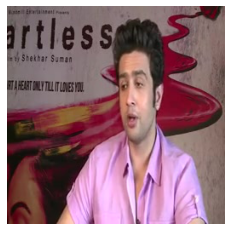

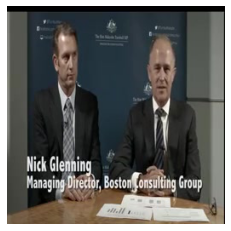

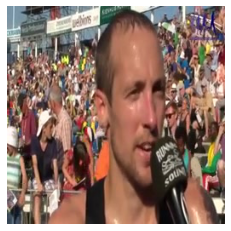

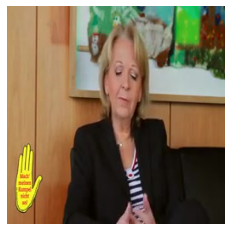

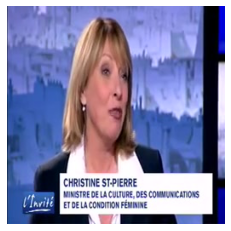

In [ ]:
# Visualize some images
from PIL import Image
import matplotlib.pyplot as plt
dset_path = "tiny_voxceleb"
vide_ids = os.listdir(dset_path)[:5]
for i in range(5): 
    frame_name = os.listdir(os.path.join(dset_path, vide_ids[i], 'frames'))[0]
    image = Image.open(os.path.join(dset_path, vide_ids[i], 'frames', frame_name))
    plt.figure()
    plt.axis('off')
    plt.imshow(image)


##Objects that sound

In this part, we'll train an audio-visual learning model. 

We'll use the VoxCeleb2 dataset to train the audio-visual learning model. We denote the $i$-th audio-visual paired sample as $\mathbf{x}^i$ and $\mathbf{s}^i$. During training, we'll have an image encoder $f$ and an audio encoder $g$ to extract visual features and audio features, respectively. 

We use a residual network to extract a 16x16x128 feature map. We use $f(\mathbf{x}_i^j) \in \mathbb{R}^{128}$ to denote the feature vector for $i$-th ($i \in \{1, ..., 256\}$) image region  in image $\mathbf{x}^j$, And we'll use a VGG-style network to extract 128-dimensional features for the audio $g(\mathbf{s}^j)$. $f(\mathbf{x}_i^j)$ and $g(\mathbf{s}^j)$ are $l$-2 normalized features. Both of the networks are implemented in **models/av_loc_model.py**. 

Following the work of [Relja Arandjelovi´ and Andrew Zisserman](https://arxiv.org/pdf/1712.06651.pdf), we can learn our model by using the correspondence of image and audio samples. Namely, given $N-1$ other random negative audio, $f(\mathbf{x}^j)$ should have a high dot product with its corresponding audio $g(\mathbf{s}^j)$, and a low dot product with every other audio example. Different from the paper, we can use contrastive learning to achieve this. For an image $x^i$, we can construct negative pairs using $N-1$ negative audio. 

We'll have two phases in training. During the first half of training epochs, the similarity between $\mathbf{x}^j$ and $\mathbf{s}^j$ is computed by averaging over all image regions. 

$$\mathcal{L}_1^i = -\log{\frac{\exp(\frac{1}{256} \sum_{k=1}^{256}{f(\mathbf{x}_k^i)^{\top}g(\mathbf{s}^i)/\tau})}{\sum_{j=1}^{N}\exp(\frac{1}{256}\sum_{k=1}^{256}{f(\mathbf{x}_k^i)^{\top}g(\mathbf{s}^j)/\tau})}}$$

, where $\tau$ is set to 0.1. During the second half of training, the similarity between $\mathbf{x}^j$ and $\mathbf{s}^j$ is computed by taking the maximum over all image regions (similar to the global max pooling operation in the paper). 

$$\mathcal{L}_2^i = -\log{\frac{\exp(\max_{k}\{{f(\mathbf{x}_k^i)^{\top}g(\mathbf{s}^i)/\tau}\})}{\sum_{j=1}^{N}\exp(\max_{k}\{{f(\mathbf{x}_k^j)^{\top}g(\mathbf{s}^i)/\tau}\})}}$$

We provide a training code template in **models/av_loc_solver.py** and a model in **models/av_loc_model.py**. Please follow the instructions and implement the loss for training the audio-visual model. 

We provide the functions for plotting and visualizing images. **You'll provide the following results.**
- Record the loss of the training data (per mini-batch) and testing data (per epoch).
- Show 100 sound source localization results. 

The training will take around 60 minutes. 

In [ ]:
from utils.data import ImgAudDset
 
exp_path = 'samples'
if not os.path.exists(exp_path): 
  os.makedirs(exp_path)
list_train = 'tiny_voxceleb/train.csv'
list_test = 'tiny_voxceleb/test.csv'
train_dataset = ImgAudDset(list_train, split='train')
test_dataset = ImgAudDset(list_test, split='test')

# sample of train: 5000
# sample of test: 100


In [ ]:
train_losses, test_losses, ssl_imgs = train_av_loc(train_dataset, test_dataset, exp_path=exp_path, quiet=False)

Output hidden; open in https://colab.research.google.com to view.

(100, 3, 256, 256)


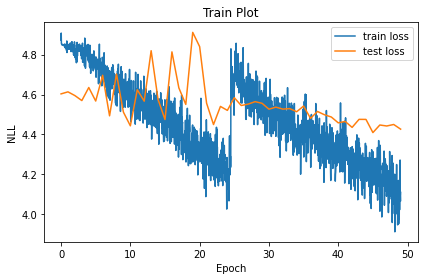

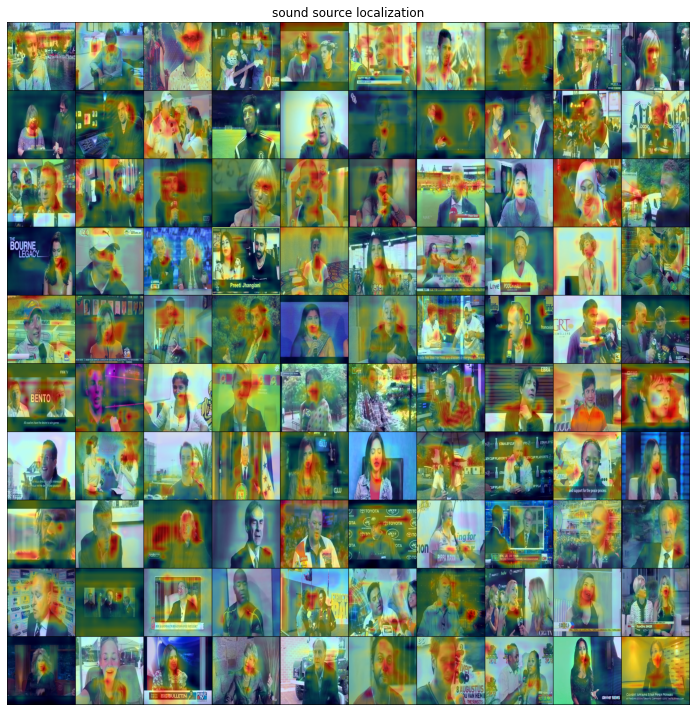

In [ ]:
from utils.vis import show_samples, save_training_plot
print(ssl_imgs.shape)
save_training_plot(train_losses, test_losses, 'Train Plot',
                    'results/av_loc_train_plot.png')
ssl_imgs = ssl_imgs[:100]
show_samples(ssl_imgs, fname='results/av_loc_samples.png', title='sound source localization', nrow=10, figsize=(10,10))